In [90]:
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [91]:
import xgboost as xgb
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from pandas.tseries.offsets import DateOffset
from itertools import product
from dateutil.relativedelta import relativedelta
from datetime import datetime
import plotly.graph_objects as go
#from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score
import boto3
import os
import io
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
data = pd.read_csv("SG_Shipments_2019_2022.csv")


In [93]:
data.style

,YearMonth,Country,Client,Product,Program,Product_Launch_Date,Make,Model_Series,Model_Series_Launch_Date,Model_Family,Predecessor,Successor,Model_Age_Days,Model,Model_No_Color,Closing_Base,Model_Capacity,Currency,Price,Price_USD,Paid_Claim,Cancelled_Claims,Shipped_Claim,Fulfilment_Type,Claim_Type,Replacement_Matrix_Offer_Type,Churn,Gross_Adds
0,202003,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,1595,256,SGD,1889.000000,1399.259776,0,0,0,0,0,0,46,11
1,202003,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,1,0,0,REPLACEMENT,OOW,0,0,0
2,202003,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,0,0,1,REPLACEMENT,OOW,LFL,0,0
3,202003,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,2,2,0,Swap,IW,0,0,0
4,202003,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,5,1,0,Swap,OOW,0,0,0
5,202003,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,0,0,4,Swap,OOW,LFL,0,0


In [94]:
shipment_data = data.copy()

In [95]:
shipment_data['YearMonth'] = shipment_data['YearMonth'].astype(str)
shipment_data['YearMonth'] = pd.to_datetime(shipment_data['YearMonth'], format='%Y%m')
shipment_data['Year'] = shipment_data['YearMonth'].dt.year
shipment_data['Month'] = shipment_data['YearMonth'].dt.month
shipment_data.drop("YearMonth", axis=1, inplace=True)

shipment_data.style


,Country,Client,Product,Program,Product_Launch_Date,Make,Model_Series,Model_Series_Launch_Date,Model_Family,Predecessor,Successor,Model_Age_Days,Model,Model_No_Color,Closing_Base,Model_Capacity,Currency,Price,Price_USD,Paid_Claim,Cancelled_Claims,Shipped_Claim,Fulfilment_Type,Claim_Type,Replacement_Matrix_Offer_Type,Churn,Gross_Adds,Year,Month
0,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,1595,256,SGD,1889.000000,1399.259776,0,0,0,0,0,0,46,11,2020,3
1,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,1,0,0,REPLACEMENT,OOW,0,0,0,2020,3
2,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,0,0,1,REPLACEMENT,OOW,LFL,0,0,2020,3
3,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,2,2,0,Swap,IW,0,0,0,2020,3
4,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,5,1,0,Swap,OOW,0,0,0,2020,3
5,Singapore,SingTel,MobileSwop Unlimited,MobileSwop Unlimited,2014-09-03,APPLE,iPhone XS,2018-09-21,APPLE IPHONE XS,APPLE IPHONE X,APPLE IPHONE 11 PRO,557,iPHXS256GLD,iPHXS256,0,256,SGD,1889.000000,1399.259776,0,0,4,Swap,OOW,LFL,0,0,2020,3


In [96]:
numerical_cols = shipment_data.select_dtypes(include=["int64", "float64"]).columns.drop('Shipped_Claim')
categorical_cols = shipment_data.select_dtypes(include=["object"]).columns
numerical_cols, categorical_cols

(Index(['Model_Age_Days', 'Closing_Base', 'Model_Capacity', 'Price',
        'Price_USD', 'Paid_Claim', 'Cancelled_Claims', 'Churn', 'Gross_Adds'],
       dtype='object'),
 Index(['Country', 'Client', 'Product', 'Program', 'Product_Launch_Date',
        'Make', 'Model_Series', 'Model_Series_Launch_Date', 'Model_Family',
        'Predecessor', 'Successor', 'Model', 'Model_No_Color', 'Currency',
        'Fulfilment_Type', 'Claim_Type', 'Replacement_Matrix_Offer_Type'],
       dtype='object'))

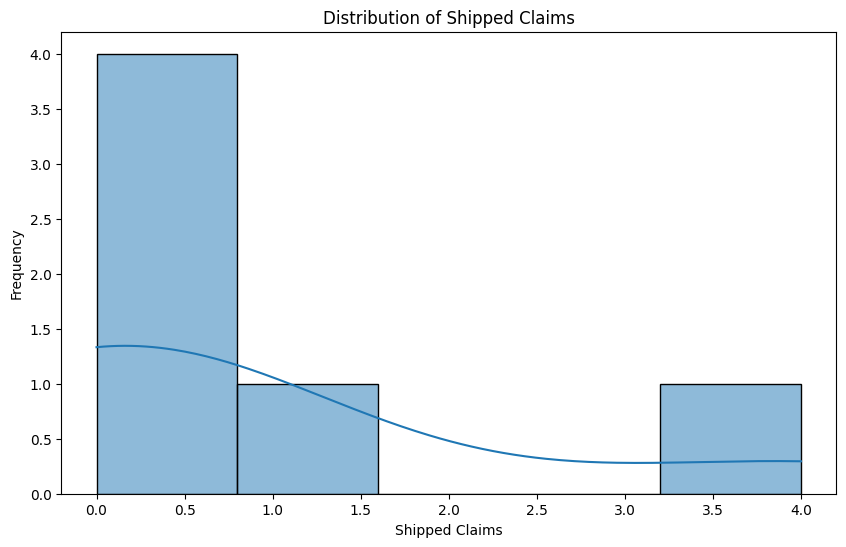

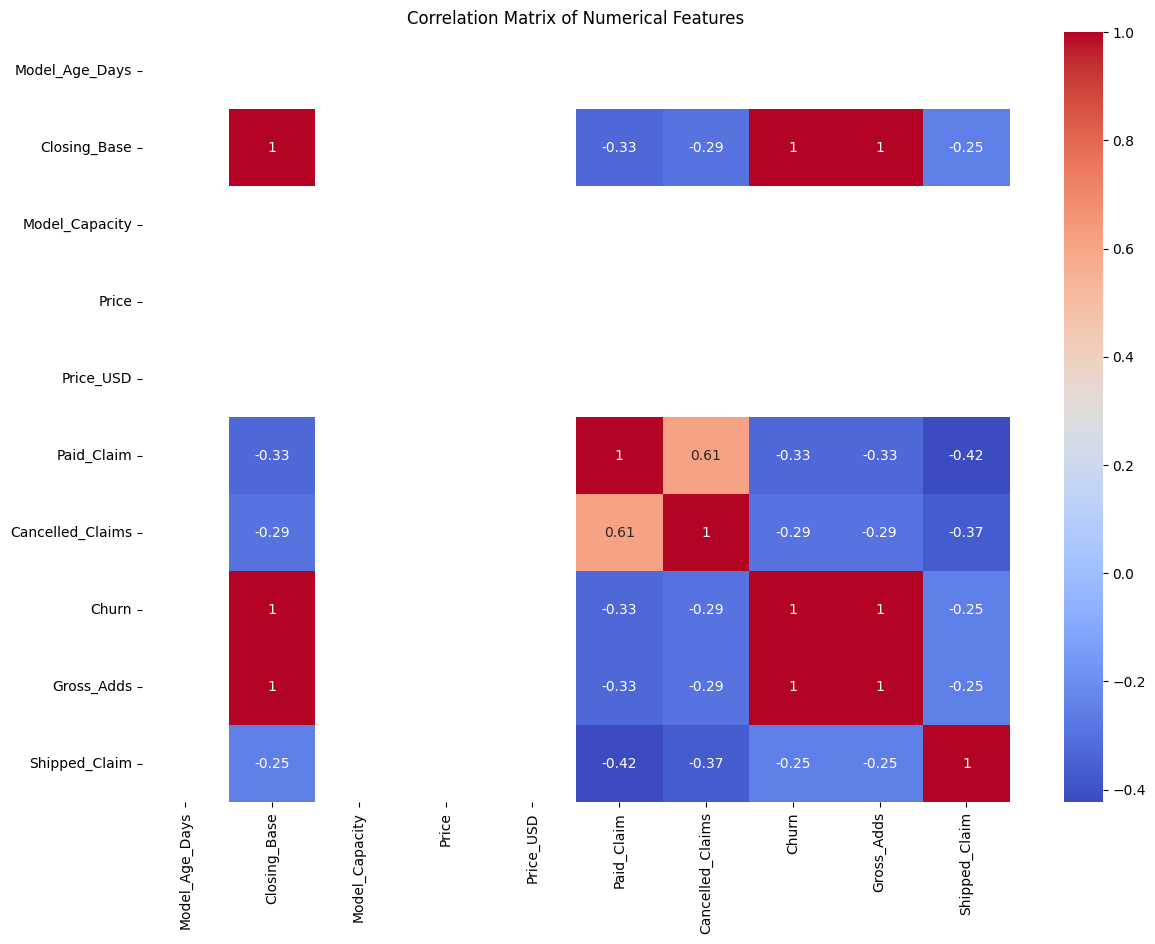

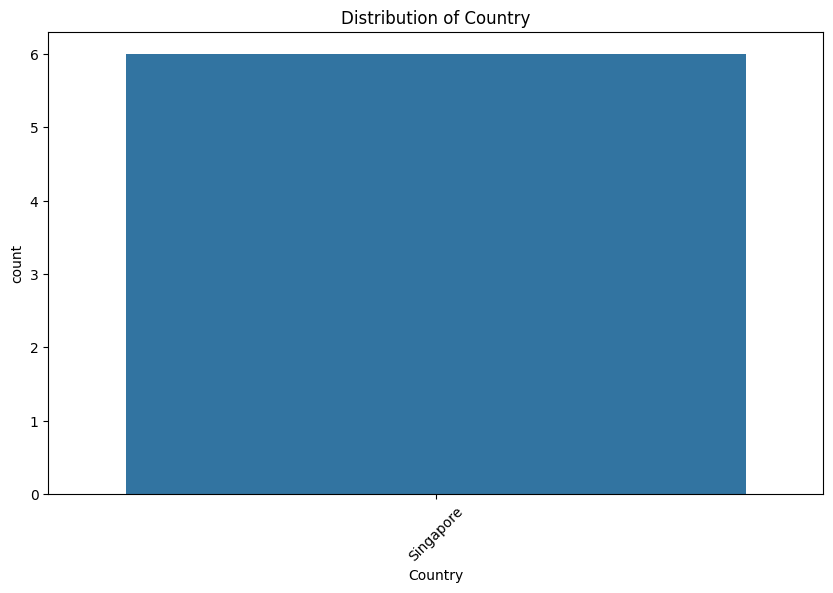

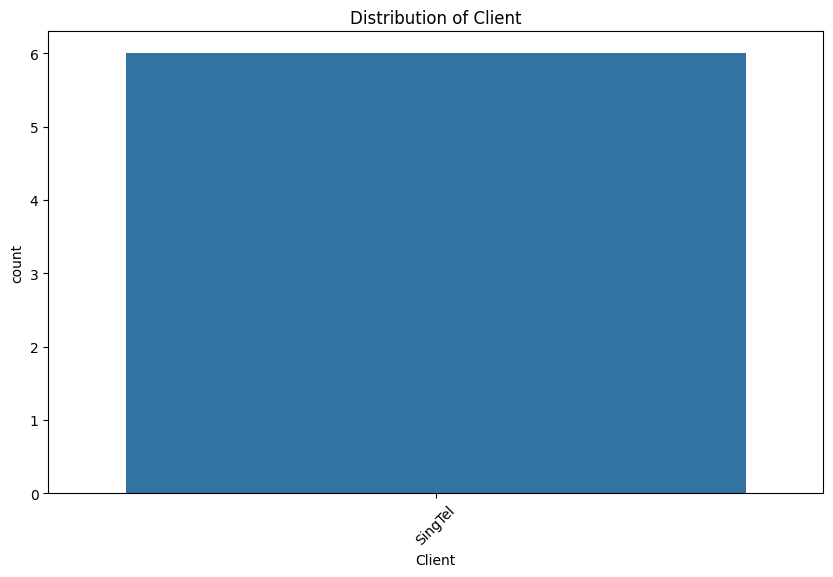

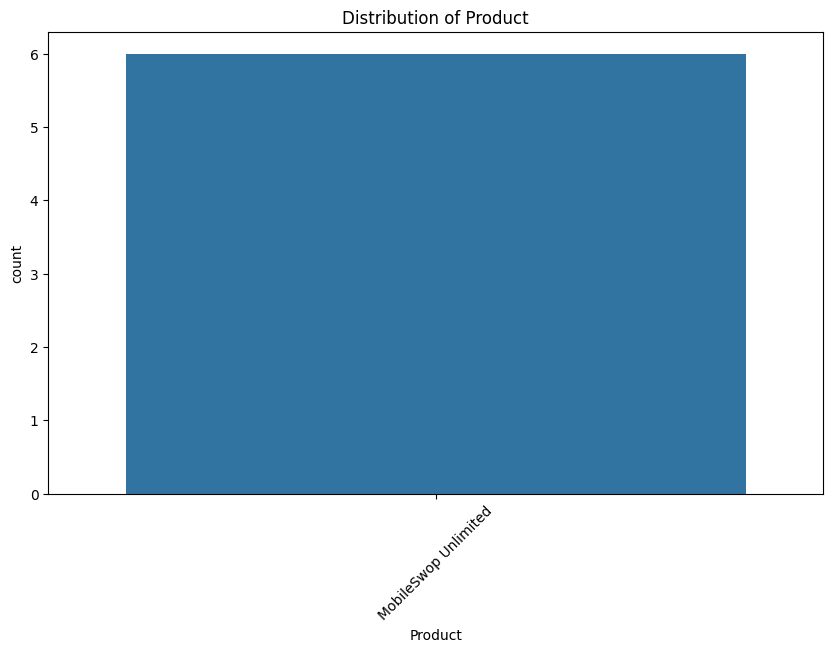

In [97]:
# some visualization, for now may not be very useful
plt.figure(figsize=(10, 6))
sns.histplot(data['Shipped_Claim'], kde=True)
plt.title('Distribution of Shipped Claims')
plt.xlabel('Shipped Claims')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(14, 10))
correlation_matrix = data[numerical_cols.append(pd.Index(['Shipped_Claim']))].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

for col in categorical_cols[:3]:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

In [98]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# one hot encoding for now
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [99]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [100]:
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model_xgb)])

X = shipment_data.drop('Shipped_Claim', axis=1)
y = shipment_data['Shipped_Claim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline_xgb.fit(X_train, y_train)

predictions_xgb = pipeline_xgb.predict(X_test)
rmse_xgb = mean_squared_error(y_test, predictions_xgb, squared=False)
r2_xgb = r2_score(y_test, predictions_xgb)

print(f"Root Mean Squared Error: {rmse_xgb}")
print(f"R2 Score: {r2_xgb}")

Root Mean Squared Error: 2.9154759474226504
R2 Score: -2.7777777777777777
